In [1]:
import pandas as pd
import json
import glob


- Uses data from ICWSM 2024 paper Machine-Made Media: Monitoring the Mobilization of Machine-GeneratedArticles on Misinformation and Mainstream News Websites

In [2]:
def read_domain_list(domains_file):
    domains = set()
    for line in open(domains_file):
        line = line.strip()
        if line.startswith("#") or not line:
            continue
        domains.add(line)
    return domains

reliable_domains = read_domain_list("reliable_domains.txt")
unreliable_domains = read_domain_list("unreliable_domains.txt")
print(f"Reliable domains: {len(reliable_domains)}")
print(f"Unreliable domains: {len(unreliable_domains)}")

Reliable domains: 2015
Unreliable domains: 1059


In [3]:
df = pd.DataFrame()
site_entries = []
from os.path import basename
for json_file in glob.glob('data_lockdown_enabled/*.json'):  # avoid /
    # print(f"Processing {json_file}")
    site_host = basename(json_file).split('_')[0]
    site_data = json.loads(open(json_file).read())
    if site_host in reliable_domains:
        site_data['reliable'] = True
    elif site_host in unreliable_domains:
        site_data['reliable'] = False
    else:
        print(f"ERROR: Unknown domain: {site_host}")
        site_data['reliable'] = None
    # print(site_data.keys())
    site_data['site'] = site_host
    site_data['json_file'] = json_file
    site_data['page_source_len'] = len(site_data['page_source'])
    site_data['inner_text_len'] = len(site_data['inner_text'])
    site_data['inner_text_256'] = site_data['inner_text'][:256]
    # del site_data['page_source']
    # del site_data['inner_text']
    site_entries.append(site_data)

df = pd.DataFrame(site_entries)
df.head()

,load_time,test_url,final_url,title,page_source,inner_text,error,page_menu,privacy_report,cert_details,reliable,site,json_file,page_source_len,inner_text_len,inner_text_256
0,4181.220,https://davejanda.com,https://davejanda.com/,Operation Freedom – Dream Big And Dare To Fail,"<html lang=""en-US"" class="" csstransforms csstr...",Skip to content\n\nLATEST PREMIUM ACCESS CONTE...,,"[Edit, Button, Page Menu, Header, Done, Button...","[Privacy Report, Button, davejanda.com, Header...","[Connection Security Details, Header, Done, Bu...",False,davejanda.com,data_lockdown_enabled/davejanda.com_20250411_0...,701666,5558,Skip to content\n\nLATEST PREMIUM ACCESS CONTE...
1,1962.016,https://alternet.org,https://www.alternet.org/,Alternet.org,"<html lang=""en""><head prefix=""og: https://ogp....",\nSCIENCE & HEALTHBELIEFCULTUREVIDEOECONOMYRIG...,,"[Edit, Button, Page Menu, Header, Done, Button...","[Privacy Report, Button, alternet.org, Header,...","[Connection Security Details, Header, Done, Bu...",True,alternet.org,data_lockdown_enabled/alternet.org_20250411_03...,832718,4400,\nSCIENCE & HEALTHBELIEFCULTUREVIDEOECONOMYRIG...
2,2365.952,https://cincinnati.com,https://eu.cincinnati.com/,Home,"<html lang=""en"" style=""--color-theme: #009BFF;...",Skip to main content\n\n\n \nWhy it's time to ...,,"[Edit, Button, Page Menu, Header, Done, Button...",[],"[Connection Security Details, Header, Done, Bu...",True,cincinnati.com,data_lockdown_enabled/cincinnati.com_20250411_...,218405,2467,Skip to main content\n\n\n \nWhy it's time to ...
3,7676.654,https://ufochroniclespodcast.com,https://ufochroniclespodcast.com/,Landing Page - UFO CHRONICLES PODCAST,"<html lang=""en-US"" class="""" style=""cursor: poi...","\n[podcast_subscribe id=""25768""]\n\nWelcome to...",,"[Edit, Button, Page Menu, Header, Done, Button...","[Privacy Report, Button, ufochroniclespodcast....","[Connection Security Details, Header, Done, Bu...",False,ufochroniclespodcast.com,data_lockdown_enabled/ufochroniclespodcast.com...,118141,201,"\n[podcast_subscribe id=""25768""]\n\nWelcome to..."
4,3186.722,https://wsvn.com,https://wsvn.com/,"Home - WSVN 7News | Miami News, Weather, Sport...","<html lang=""en-US"" class=""js""><head><script ty...","Skip to content\nWSVN 7News | Miami News, Weat...",,"[Edit, Button, Page Menu, Header, Done, Button...","[Privacy Report, Button, wsvn.com, Header, TRA...","[Connection Security Details, Header, Done, Bu...",True,wsvn.com,data_lockdown_enabled/wsvn.com_20250411_034746...,1005714,8393,"Skip to content\nWSVN 7News | Miami News, Weat..."


In [4]:

def get_trackers_from_privacy_report(report):
    found_tracker_header = False
    trackers = []
    for item in report:
        # print(item)
        if item == "TRACKERS PREVENTED FROM PROFILING YOU, Header":
            found_tracker_header = True
            continue
        if not found_tracker_header: # skip the preamble
            continue
        if ", " not in item:
            print(f"Unexpected line: {item}")
            continue
        domain, entity = item.split(", ")
        trackers.append({
            'domain': domain,
            'entity': entity
        })
    return trackers


df['trackers'] = df.privacy_report.map(get_trackers_from_privacy_report)
df['n_trackers'] = df.trackers.map(lambda x: len(x))


In [5]:
len(df)

96

In [6]:
ERROR_MSGS = [
    "Safari can’t open the page",
    "Oops, an error occurred",
    "451: Unavailable due to legal reasons",
    "403 Forbidden\n\nopenresty",
    "There has been a critical error on this website",
    "Sorry, you have been blocked",
    "not available in your region",
    "Verifying you are human",
    "This blog may contain sensitive content.",
]

df['load_error'] = ""
for msg in ERROR_MSGS:
    df.loc[df.inner_text_256.str.contains(msg), 'load_error'] = msg
df.loc[df.inner_text_256 == "", 'load_error'] = "Blank page"
df.load_error.value_counts()

load_error
                                                   80
Blank page                                          3
not available in your region                        3
451: Unavailable due to legal reasons               2
Safari can’t open the page                          2
Oops, an error occurred                             1
This blog may contain sensitive content.            1
Verifying you are human                             1
403 Forbidden\n\nopenresty                          1
Sorry, you have been blocked                        1
There has been a critical error on this website     1
Name: count, dtype: int64

In [7]:
df[(df.load_error != "")].test_url.unique()

array(['https://questlifefellowship.com',
       'https://initiative-corona.info', 'https://kcra.com',
       'https://postregister.com', 'https://frontiersman.com',
       'https://libertyhangout.org', 'https://gishgallop.com',
       'https://steadfastandloyal.com', 'https://wetheonepeople.com',
       'https://lancastercourier.com', 'https://thelibertyloft.com',
       'https://escapeallthesethings.com',
       'https://homelandsecuritynewswire.com', 'https://pilotonline.com',
       'https://wisn.com', 'https://americasnewssource.com'], dtype=object)

In [8]:
df = df[(df.load_error == "")]
df.reliable.value_counts()

reliable
False    40
True     40
Name: count, dtype: int64

In [ ]:
reliable_count = df.reliable.value_counts()[True]
unreliable_count = df.reliable.value_counts()[False]
print(f"Reliable count: {reliable_count}")
print(f"Unreliable count: {unreliable_count}")
if reliable_count > unreliable_count:
    print(f"Will drop {reliable_count - unreliable_count} reliable rows")
    df = df.drop(df[df.reliable == True].sample(reliable_count - unreliable_count).index)
else:
    print(f"Will drop {unreliable_count - reliable_count} unreliable rows")
    df = df.drop(df[df.reliable == False].sample(unreliable_count - reliable_count).index)
print(f"Reliable and Unreliable count after equalizing:")
df.reliable.value_counts()

Reliable count: 40
Unreliable count: 40
Will drop 0 unreliable rows
Reliable and Unreliable count after equalizing:


reliable
False    40
True     40
Name: count, dtype: int64

In [10]:
# find the most common trackers
from collections import defaultdict, Counter


def get_tracker_counts(df, ntop=10):
    domain_counts = Counter()
    entity_sites = defaultdict(set)
    for site_url, tracker_list in df[["test_url", "trackers"]].values:
        # print(f"Processing {site_url}")
        for tracker in tracker_list:
            domain = tracker['domain']
            domain_counts[domain] += 1
            entity = tracker['entity']
            entity_sites[entity].add(site_url)
    # display a table of the counts
    print("Top tracker entities:")
    entity_counts = {}
    for entity, sites in entity_sites.items():
        # print(f"{entity}: {len(sites)}")
        entity_counts[entity] = len(sites)

    entity_counts = sorted(entity_counts.items(), key=lambda x: x[1], reverse=True)
    for entity, count in entity_counts[:ntop]:
        print(f"{entity}: {count}")

    print("")
    print("Top tracker domains:")
    for domain, count in domain_counts.most_common(ntop):
        print(f"{domain}: {count}")
    # return domain_counts

# get_tracker_counts(df[df.reliable == True])
# get_tracker_counts(df[df.reliable == False])
get_tracker_counts(df)
print("Total sites:", len(df))


Top tracker entities:
Google: 62
Cloudflare: 14
Amazon.com: 13
Facebook: 13
Criteo: 11
ID5: 10
PubMatic: 10
Twitter: 10
WarnerMedia: 9
The Trade Desk: 9

Top tracker domains:
google.com: 48
google-analytics.com: 46
googletagmanager.com: 44
doubleclick.net: 38
googlesyndication.com: 23
cloudflare.com: 14
amazon-adsystem.com: 13
facebook.net: 12
youtube.com: 11
criteo.com: 11
Total sites: 80


In [11]:
get_tracker_counts(df[df.reliable == True])


Top tracker entities:
Google: 31
Cloudflare: 12
Criteo: 10
Amazon.com: 10
PubMatic: 9
Facebook: 9
ID5: 8
The Trade Desk: 8
WarnerMedia: 7
Taboola: 7

Top tracker domains:
doubleclick.net: 28
googletagmanager.com: 26
google-analytics.com: 24
google.com: 24
googlesyndication.com: 12
cloudflare.com: 12
criteo.com: 10
amazon-adsystem.com: 10
pubmatic.com: 9
id5-sync.com: 8


In [31]:
get_tracker_counts(df[df.reliable == False], 10)


Top tracker entities:
Google: 31
Adscore: 5
OneSignal: 5
Facebook: 4
Prospect One: 4
PayPal: 3
MGID: 3
Amazon.com: 3
Twitter: 3
Intuit: 2

Top tracker domains:
google.com: 24
google-analytics.com: 22
googletagmanager.com: 18
googlesyndication.com: 11
doubleclick.net: 10
youtube.com: 6
adsco.re: 5
onesignal.com: 5
facebook.net: 4
jsdelivr.net: 4


<Axes: ylabel='n_trackers'>

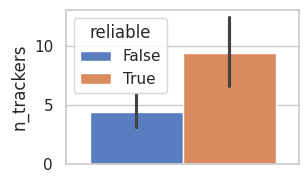

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
# fig size
plt.figure(figsize=(3, 2))
# plot the number of trackers, vs reliable
sns.set_theme(style="whitegrid")

sns.barplot(y="n_trackers", hue="reliable", data=df, palette="muted")


In [14]:
# table median and mean num of trackers per reliability
print("Mean number of trackers per reliability:")
print(df.groupby('reliable')['n_trackers'].mean())
print("Median number of trackers per reliability:")
print(df.groupby('reliable')['n_trackers'].median())
# table median and mean num of trackers per reliability


Mean number of trackers per reliability:
reliable
False    4.4
True     9.4
Name: n_trackers, dtype: float64
Median number of trackers per reliability:
reliable
False    3.0
True     7.0
Name: n_trackers, dtype: float64


In [15]:
# check if the difference in means is significant
from scipy import stats

reliable = df[df.reliable == True].n_trackers
unreliable = df[df.reliable == False].n_trackers
t_stat, p_val = stats.ttest_ind(reliable, unreliable)
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_val}")

T-statistic: 3.193046402882847
P-value: 0.002030765347530635


In [16]:
df[['test_url', 'reliable', 'n_trackers']].sort_values('n_trackers', ascending=False).head(10)

,test_url,reliable,n_trackers
54,https://jezebel.com,True,31
80,https://postandcourier.com,True,28
20,https://greeleytribune.com,True,26
75,https://skyhinews.com,True,24
27,https://twitchy.com,False,23
29,https://daily-journal.com,True,22
34,https://listverse.com,True,20
63,https://nbcphiladelphia.com,True,20
87,https://kgns.tv,True,19
4,https://wsvn.com,True,19


In [17]:
df[df.n_trackers == 0].reliable.value_counts()

reliable
True     8
False    5
Name: count, dtype: int64

In [18]:
df[['test_url', 'reliable', 'n_trackers']].sort_values('n_trackers', ascending=True).head(20)

,test_url,reliable,n_trackers
68,https://insideclimatenews.org,True,0
71,https://therightstuff.biz,False,0
61,https://pix11.com,True,0
44,https://rationalground.com,False,0
55,https://tennessean.com,True,0
51,https://colorado911truth.org,False,0
47,https://sctimes.com,True,0
84,https://abc27.com,True,0
41,https://ocala.com,True,0
43,https://wearegreenbay.com,True,0


In [19]:
# compare page load time v reliability
# sns.scatterplot(data=df, x='load_time', y='n_trackers', hue='reliable')
print(df.groupby('reliable')['load_time'].mean())


reliable
False    2978.738500
True     3413.315675
Name: load_time, dtype: float64


In [20]:
def get_issuer_names(cert_details):
    issuer_names = []
    assert "This certificate is valid" in cert_details
    # get the index of "Issued to"
    index_it = cert_details.index("Issued to")
    issued_to = cert_details[index_it+1]
    index_st = cert_details.index("Signed by")
    signed_by = cert_details[index_st+1]
    assert signed_by == issued_to
    # print(f"Issued to: {issued_to} {signed_by}")
    return signed_by
    # for item in cert_details:
    #     if item == "Issued to":
    #         continue
    #     if isinstance(cert, str):
    #         cert = json.loads(cert)
    #     if 'issuer' in cert:
    #         issuer_names.append(cert['issuer'])
    #     else:
    #         issuer_names.append("")
    # return issuer_names
# df.cert_0details.value_counts()
df['cert_signer'] = df.cert_details.map(get_issuer_names)

In [21]:
CA_DICT = {
    "WE1": "Google",
    "WR1": "Google",
    "WR2": "Google",
    "R10": "Let's Encrypt",
    "R11": "Let's Encrypt",
    "E5": "Let's Encrypt",
    "E6": "Let's Encrypt",
    "GlobalSign Atlas R3 DV TLS CA 2025 Q1": "GlobalSign",
    "GlobalSign Atlas R3 DV TLS CA 2025 Q2": "GlobalSign",
    "GlobalSign Atlas R3 DV TLS CA 2025 Q3": "GlobalSign",
    "GlobalSign Atlas R3 DV TLS CA 2025 Q4": "GlobalSign",
    "GlobalSign Atlas R3 DV TLS CA 2024 Q3": "GlobalSign",
    "Sectigo RSA Domain Validation Secure Server CA": "Sectigo",
    "DigiCert TLS RSA SHA256 2020 CA1": "DigiCert",
    "Go Daddy Secure Certificate Authority - G2": "GoDaddy",
    "Amazon RSA 2048 M02": "Amazon",
    # add more as needed
}
df['ca_name'] = df.cert_signer.map(lambda x: CA_DICT.get(x, x))
df['ca_name'].value_counts()

ca_name
Google           39
Let's Encrypt    33
GlobalSign        2
Amazon            2
Sectigo           2
GoDaddy           1
DigiCert          1
Name: count, dtype: int64

In [22]:
df[df.reliable].ca_name.value_counts().sort_values(ascending=False).head(20)

ca_name
Let's Encrypt    20
Google           14
GlobalSign        2
Amazon            2
Sectigo           1
DigiCert          1
Name: count, dtype: int64

In [23]:
df[~df.reliable].ca_name.value_counts().sort_values(ascending=False).head(20)

ca_name
Google           25
Let's Encrypt    13
GoDaddy           1
Sectigo           1
Name: count, dtype: int64

In [24]:
df[~df.reliable & (df.cert_signer == "WE1")].test_url.unique()

array(['https://davejanda.com', 'https://pandemic.news',
       'https://newsready.com', 'https://barenakedislam.com',
       'https://defiantamerica.com', 'https://911nwo.com',
       'https://lewrockwell.com', 'https://twisted.news',
       'https://thebeltwayreport.com', 'https://twitchy.com',
       'https://canadafreepress.com', 'https://redstatenation.com',
       'https://dcdirtylaundry.com',
       'https://americanconservativemovement.com',
       'https://brighteon.com', 'https://campusinsanity.com',
       'https://qalerts.net', 'https://renewedright.com',
       'https://colorado911truth.org', 'https://therightstuff.biz',
       'https://newssloth.com', 'https://conservativefreepress.com',
       'https://altleft.news', 'https://theblacksphere.net'], dtype=object)

In [25]:
df['cert_signer'].value_counts()

cert_signer
WE1                                               35
R10                                               14
R11                                               10
E6                                                 5
E5                                                 4
WR1                                                3
Amazon RSA 2048 M02                                2
Sectigo RSA Domain Validation Secure Server CA     2
GlobalSign Atlas R3 DV TLS CA 2024 Q3              1
Go Daddy Secure Certificate Authority - G2         1
DigiCert TLS RSA SHA256 2020 CA1                   1
WR2                                                1
GlobalSign Atlas R3 DV TLS CA 2025 Q1              1
Name: count, dtype: int64

In [28]:
df.test_url.value_counts()

test_url
https://skyhinews.com               1
https://newamerica.org              1
https://911truthout.blogspot.com    1
https://qanonpress.wordpress.com    1
https://postandcourier.com          1
                                   ..
https://ufochroniclespodcast.com    1
https://wsvn.com                    1
https://pandemic.news               1
https://wingsoverscotland.com       1
https://voiceofsandiego.org         1
Name: count, Length: 80, dtype: int64